# 📊 Statistical Analysis of the Clinical Case Dataset

This notebook performs a detailed statistical analysis of the clinical case dataset used for MeSH-C classification. Its main goals are to justify dataset filtering decisions and to explore the linguistic and label structure of the data.

## Objectives

- Justify the exclusion of specific clinical cases based on filtering criteria  
- Identify the Top 20 most frequent general words and medical terms in `case_text`  
- Compute statistics on word and token counts per case  
- Calculate the average number of MeSH-C classes per document  
- Plot the distribution of MeSH-C classes across the dataset  
- Analyze pairwise correlations between MeSH-C categories

## Import data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Barre de progression pour Jupyter
pd.set_option('display.max_colwidth', None)
from IPython.display import display, Markdown

import nltk
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
import re

## Analysis of labels attached to selected clinical cases


In [ ]:
os.chdir('/home/onyxia/work/projet_NLP')
os.getcwd()

'/home/onyxia/work/projet_NLP'

In [6]:
df = pd.read_pickle('data/df_full.pkl')
print(df.shape)
print(df.columns)

(10718, 12)
Index(['pmcid', 'title', 'gender', 'case_text', 'keywords', 'major_mesh_terms',
       'mesh_terms', 'journal', 'doi', 'dict_mesh', 'codes_mesh_extraits',
       'target'],
      dtype='object')


In [7]:
pd.set_option('display.max_colwidth', 200)  # diplay a maximum of 200 characters
df.sample(2)

,pmcid,title,gender,case_text,keywords,major_mesh_terms,mesh_terms,journal,doi,dict_mesh,codes_mesh_extraits,target
5626,PMC4408939,Canakinumab as rescue therapy in familial Mediterranean fever refractory to conventional treatment,Female,A 30-year-old Bolivian woman with familial Mediterranean fever (FMF) was referred to our Centre of Research on Immunopathology and Rare Diseases (CMID) in November 2010 because of remitting fever ...,"[anti-il-1 treatment, biologic agents, colchicine, familial mediterranean fever, interleukin-1]","[Antibodies, Monoclonal / therapeutic use, Familial Mediterranean Fever / drug therapy]","[Antibodies, Monoclonal / therapeutic use, Familial Mediterranean Fever / drug therapy, Case Reports, Adult, Antibodies, Monoclonal / adverse effects, Antibodies, Monoclonal, Humanized, Colchicine...",Drug Des Devel Ther,10.2147/DDDT.S69117,"{'therapeutic use': {'Antibodies, Monoclonal'}, 'drug therapy': {'Familial Mediterranean Fever'}}",[16],"[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False]"
7328,PMC7145984,Eculizumab Treatment for Postpartum HELLP Syndrome and aHUS-Case Report,Male,"Twenty-nine year old primigravida was referred at gestational age 34+2 to the Helsinki University hospital outpatient clinic with upper stomach pain. Initially, her blood pressure was modestly ele...","[hellp, ahus, case report, eculizumab, preeclampsia, thrombotic microangiopathy]","[Antibodies, Monoclonal, Humanized / therapeutic use, Atypical Hemolytic Uremic Syndrome / drug therapy, Complement Inactivating Agents / therapeutic use, HELLP Syndrome / drug therapy, Pre-Eclamp...","[Antibodies, Monoclonal, Humanized / therapeutic use, Atypical Hemolytic Uremic Syndrome / drug therapy, Complement Inactivating Agents / therapeutic use, HELLP Syndrome / drug therapy, Pre-Eclamp...",Front Immunol,10.3389/fimmu.2020.00548,"{'therapeutic use': {'Antibodies, Monoclonal, Humanized', 'Complement Inactivating Agents'}, 'drug therapy': {'HELLP Syndrome', 'Atypical Hemolytic Uremic Syndrome'}, 'No Qualifier': {'Pre-Eclamps...","[12, 15]","[False, False, False, False, False, False, False, False, False, False, False, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False]"


In [7]:
# On convertit chaque élément en array bool explicite
target_array = np.vstack(df['target'].apply(lambda x: np.array(x, dtype=bool)))

In [8]:
MeSH_vides = df[df['target'].apply(lambda x: not any(x))]
print("nombre cas sans code MeSH catégorie 'disease' :", MeSH_vides.shape)

df = df.drop(MeSH_vides.index)

nombre cas sans code MeSH catégorie 'disease' : (667, 12)


In [10]:
keys = [f"C{str(i).zfill(2)}" for i in range(1, 27)]
values = target_array.sum(axis=0)
result = dict(zip(keys, values))

cas_par_classes = pd.DataFrame.from_dict(result, orient='index', columns=['nombre_cas'])
cas_par_classes

,nombre_cas
C01,2343
C02,0
C03,0
C04,2998
C05,1008
C06,1519
C07,392
C08,1567
C09,261
C10,2136


In [11]:
print("nombre de classes avec 100+ cas :", (cas_par_classes > 100).sum().iloc[0])
print("nombre de classes avec 1000+ cas :", (cas_par_classes > 1000).sum().iloc[0])

nombre de classes avec 100+ cas : 20
nombre de classes avec 1000+ cas : 13


In [12]:
print("Nombre de label au total: ", cas_par_classes.sum().iloc[0])
print("Nombre de catégorie par cas clinique en moyenne: ", round((cas_par_classes.sum().iloc[0] / df.shape[0]),2))
print("Nombre de cas par catégorie moyenne: ", round((cas_par_classes.sum().iloc[0] / 23),2))


Nombre de label au total:  27367
Nombre de catégorie par cas clinique en moyenne:  2.72
Nombre de cas par catégorie moyenne:  1189.87


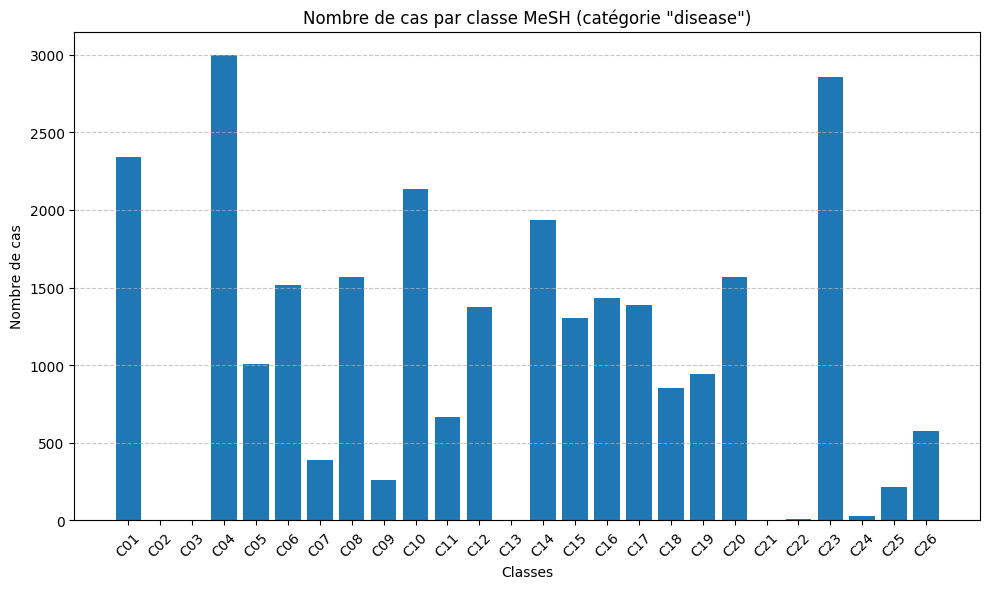

In [13]:
# Tracer un barplot
plt.figure(figsize=(10, 6))
plt.bar(cas_par_classes.index, cas_par_classes['nombre_cas'])
plt.xlabel('Classes')
plt.ylabel('Nombre de cas')
plt.title('Nombre de cas par classe MeSH (catégorie "disease")')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Matrice de corrélation entre les classes

In [27]:
import numpy as np
import pandas as pd

# 1. Ton array de base
arr_int = target_array.astype(int)

# 2. Générer TOUS les noms d'origine
full_category_names = [f"C{str(i+1).zfill(2)}" for i in range(arr_int.shape[1])]

# 3. Détecter colonnes non constantes
non_constant_columns = arr_int.std(axis=0) != 0

# 4. Réduire arr_int en gardant trace
arr_int = arr_int[:, non_constant_columns]

# 5. Garder uniquement les catégories non constantes
category_names = [name for name, keep in zip(full_category_names, non_constant_columns) if keep]

# 6. Calcul de la corrélation
correlation_matrix = np.corrcoef(arr_int, rowvar=False)

# 7. Masquer le triangle inférieur
mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))
correlation_matrix = np.where(mask, np.nan, correlation_matrix)

# 8. Créer un DataFrame avec les noms corrects
correlation_df = pd.DataFrame(correlation_matrix, index=category_names, columns=category_names)

# 9. Fonction de stylisation
def style_corr(val):
    if pd.isna(val):
        return ""
    style = ""
    if abs(val) > 0.10:
        style += "font-weight: bold;"
    return style

# 10. Appliquer le style
styled_corr = (
    correlation_df.style
    .format(precision=2, na_rep="")  # 2 chiffres
    .background_gradient(cmap='RdYlGn', vmin=-1, vmax=1)  # couleurs
    .applymap(style_corr)  # gras si |corr| > 0.10
    .set_properties(**{'font-size': '10pt'})  # taille police
    .set_caption("Matrice de corrélation (triangle supérieur) entre classes MeSH C01 à C26")
)

# 11. Afficher
styled_corr

/tmp/ipykernel_11010/976907673.py:43: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(style_corr)  # gras si |corr| > 0.10


,C01,C04,C05,C06,C07,C08,C09,C10,C11,C12,C14,C15,C16,C17,C18,C19,C20,C22,C23,C24,C25,C26
C01,,-0.19,-0.05,-0.00,-0.02,0.27,0.01,-0.06,-0.02,0.03,-0.09,-0.01,-0.14,-0.00,-0.09,-0.09,0.05,0.05,-0.02,-0.01,-0.01,-0.08
C04,,,0.00,0.15,0.06,0.01,0.04,-0.05,-0.06,0.07,-0.13,0.16,-0.12,0.03,-0.08,0.17,0.08,-0.02,-0.12,-0.02,-0.07,-0.11
C05,,,,-0.08,0.12,-0.05,0.03,0.06,0.01,-0.05,-0.06,-0.04,0.12,0.08,0.06,0.01,0.01,-0.01,-0.04,-0.00,-0.03,0.05
C06,,,,,-0.03,-0.08,-0.01,-0.15,-0.09,-0.04,-0.10,-0.02,-0.02,-0.06,0.01,0.03,-0.04,0.03,0.07,-0.01,0.00,-0.03
C07,,,,,,-0.03,0.18,-0.02,0.09,-0.03,-0.02,-0.02,0.03,0.10,-0.03,-0.05,0.02,-0.00,-0.02,-0.00,0.05,-0.03
C08,,,,,,,0.14,-0.09,-0.06,-0.07,-0.02,-0.01,-0.06,-0.05,-0.06,-0.04,0.01,-0.01,-0.02,0.06,-0.02,-0.04
C09,,,,,,,,0.07,0.01,-0.03,-0.01,-0.01,0.01,-0.01,-0.02,-0.02,-0.02,-0.00,0.05,0.00,-0.02,-0.01
C10,,,,,,,,,0.12,-0.09,0.03,-0.08,0.09,-0.06,0.06,0.03,0.02,-0.00,0.13,-0.01,-0.01,0.08
C11,,,,,,,,,,-0.07,-0.01,-0.04,0.08,0.05,-0.01,-0.03,0.03,0.02,0.01,0.00,-0.02,-0.00
C12,,,,,,,,,,,-0.07,-0.02,-0.00,-0.04,0.02,0.12,0.06,-0.01,0.02,-0.01,-0.02,-0.05


In [15]:
# Flatten the upper triangle of correlation_df
corr_values = correlation_df.values.flatten()

# Drop NaN values (masked lower triangle)
corr_values = corr_values[~np.isnan(corr_values)]

# Now define the correct ranges
count_no_corr = np.sum((corr_values >= -0.10) & (corr_values < 0.10))
count_low_corr = np.sum(((corr_values >= -0.20) & (corr_values < -0.10)) | ((corr_values >= 0.10) & (corr_values < 0.20)))
count_moderate_corr = np.sum(((corr_values >= -0.30) & (corr_values < -0.20)) | ((corr_values >= 0.20) & (corr_values < 0.30)))
count_strong_corr = np.sum((corr_values <= -0.30) | (corr_values >= 0.30))

# Display
print(f"Nombre de corrélations entre [-0.10, 0.10) (quasi nulles) : {count_no_corr}")
print(f"Nombre de corrélations entre [-0.20, -0.10) ou [0.10, 0.20) (faibles) : {count_low_corr}")
print(f"Nombre de corrélations entre [-0.30, -0.20) ou [0.20, 0.30) (modérées) : {count_moderate_corr}")
print(f"Nombre de corrélations ≤ -0.30 ou ≥ 0.30 (fortes) : {count_strong_corr}")

Nombre de corrélations entre [-0.10, 0.10) (quasi nulles) : 208
Nombre de corrélations entre [-0.20, -0.10) ou [0.10, 0.20) (faibles) : 19
Nombre de corrélations entre [-0.30, -0.20) ou [0.20, 0.30) (modérées) : 3
Nombre de corrélations ≤ -0.30 ou ≥ 0.30 (fortes) : 1


In [15]:
print(correlation_df.shape)

(22, 22)


## Analyse case_text

In [ ]:
# Statistiques nombre de caractères
df['case_text'].str.len().describe().astype(int)

count    10051
mean      3502
std       2399
min        145
25%       2004
50%       3012
75%       4343
max      60512
Name: case_text, dtype: int64

In [18]:
# Statistiques nombre de mots
df['case_text'].apply(lambda x: len(str(x).split())).describe().astype(int)

count    10051
mean       524
std        360
min         25
25%        300
50%        452
75%        648
max       8797
Name: case_text, dtype: int64

### Nuage de mots ordinaires

In [19]:

from nltk.corpus import stopwords 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/onyxia/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
text_brut = " ".join(df['case_text'].astype(str))
STOPWORDS = set(stopwords.words('english'))

# Nettoyer et découper en mots
words = re.findall(r'\b\w+\b', text_brut.lower())
words = [word for word in words if word not in STOPWORDS and len(word) > 2]

# Compte les occurrences des mots
term_counts = Counter(words)

# Prend les 20 mots les plus fréquents
most_common_terms = term_counts.most_common(20)

# Affiche proprement en texte
print("Top 20 des mots les plus fréquents :")
for term, count in most_common_terms:
    print(f"{term}: {count}")

Top 20 des mots les plus fréquents :
patient: 42208
showed: 21150
figure: 19926
normal: 17939
revealed: 16054
left: 15717
right: 15197
day: 14040
blood: 13655
examination: 12687
treatment: 11966
year: 11738
performed: 10850
old: 10724
fig: 10646
history: 10253
months: 10033
cells: 9616
days: 8983
also: 8185


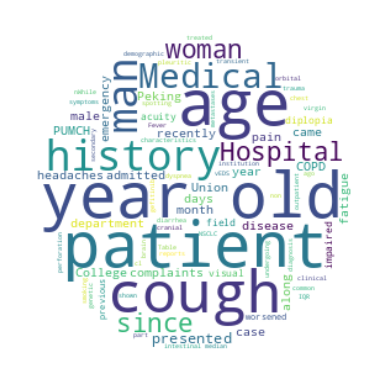

In [22]:
# Display one wordcloud for each of the most frequent classes
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

# plot a word cloud
text = str(df['case_text'])
wc = WordCloud(background_color="white", repeat=True, mask=mask, stopwords = STOPWORDS)
wc.generate(text)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

### Nuage de mots médicaux

In [23]:
import spacy
import scispacy
from scispacy.linking import EntityLinker
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Load the Med7 model
nlp = spacy.load("en_core_sci_sm")

# Ajouter un linker vers UMLS (si tu veux mapper les entités à des concepts médicaux précis)
linker = EntityLinker(resolve_abbreviations=True, name="umls")
nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": "umls"})

/usr/local/lib/python3.11/site-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


/usr/local/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.1.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [24]:
# Échantillon aléatoire de 250 lignes (modifiable)
sample_df = df.sample(n=250, random_state=42)
text = " ".join(sample_df['case_text'].astype(str))

# Applique le modèle NLP sur tout le texte d’un coup (plus rapide et propre)
doc = nlp(text)

# Récupère les entités détectées
medical_terms = [ent.lemma_.lower() for ent in doc.ents]

# Ajoute des mots personnalisés si besoin
additional_terms = ["one", "two", "three", "day", "daily", "month"]
medical_terms.extend(additional_terms)

In [25]:
from collections import Counter

# Compte les occurrences des termes médicaux
term_counts = Counter(medical_terms)

# Affiche les 20 termes les plus fréquents
most_common_terms = term_counts.most_common(20)

# Affichage propre
print("Top 20 des termes médicaux les plus fréquents :")
for term, count in most_common_terms:
    print(f"{term}: {count}")

Top 20 des termes médicaux les plus fréquents :
patient: 936
day: 370
month: 287
increase: 200
treatment: 197
week: 190
year: 186
level: 180
negative: 179
diagnosis: 154
figure: 147
diagnose: 132
admission: 125
lesion: 125
patient's: 122
finding: 117
case: 115
positive: 114
hospital: 103
decrease: 102


['male', 'admit', 'department of surgery', 'clinical emergency hospital', 'bucharest', 'height', 'meter', 'multiple trauma', 'haemoperitoneum', 'splenic rupture', 'blunt bladder injury', 'microscopic', 'hematuria', 'mild cerebral contusion', 'retrograde', 'amnesia', 'facial abrasion', 'blunt ch trauma', 'blunt right knee injury', 'medical history', 'hepatitis c virus infection', 'admission', 'gcs=15', 'retrograde', 'amnesia', 'bp=122/70 mmhg', 'hr=75/min', 'sinus rhythm', 'rr=14/min', 'abdoman', 'soft', 'no rebound', 'guarding', 'tender', 'left upper quadrant', 'epigastrium', 'abdominal ultrasound', 'perisplenic fluid', 'hypoechoic splenic area', 'contrast ct', 'splenic laceration', 'spleen', 'upper pole', 'capsule disruption', 'splenic pedicle', 'perihepatic', 'perisplenic', 'blood', 'pelvis', 'presence', 'grade iv splenic injury', 'aast-ois', 'moderate', 'haemoperitoneum', 'performance', 'splenic angiography', 'heterogeneous', 'contrast', 'splenic parenchyma', 'contrast extravasation

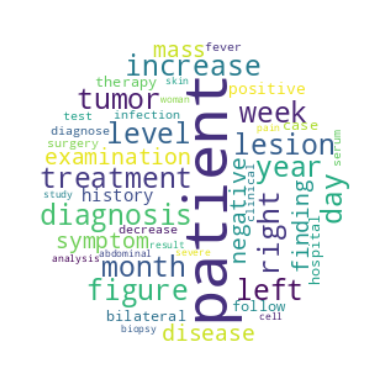

In [26]:
# Génère le nuage de mots
medical_bagofwords = " ".join(medical_terms)
print(medical_terms)

wc = WordCloud(background_color="white", repeat=True, mask=mask, stopwords=STOPWORDS)
wc.generate(medical_bagofwords)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()